# Efficient depth-one tests

This notebook is a test for the efficient depth-one code to align the conventions. The convention in this repository is that the (depth-one) QAOA should create an Ansatz of the form

\begin{align}
\exp\left(-i\beta H_m\right)\exp\left(-i\gamma H_c\right)\vert+\rangle^{\otimes n}
\end{align}

to **minimize** the energy of $H_c$. Since we are minimizing $\langle H_c\rangle$, the initial state of the ansatz should be the ground state of the mixer $H_m$. This enforces
\begin{align}
H_m=-\sum_iX_i.
\end{align}
As cost operator we apply
\begin{align}
H_c=\sum_{i,j=0}^{n-1}w_{i,j}Z_iZ_j
\end{align}
At the circuit level, these definitions imply that the exponential of the mixer is built with $R_x(-2\beta)$ rotations and the exponential of the cost operator is built from $R_{zz}(2\gamma w_{i,j})$.

In [2]:
paulis = [
    ["IIZZ", 1.0],
    ["IZIZ", 1.0],
    ["ZZII", 1.0],
    ["ZIIZ", 1.0],
]

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.providers.aer import AerSimulator

from large_scale_qaoa.qaoa import ErrorMitigationQAOA
from large_scale_qaoa.efficient_depth_one import energy

In [4]:
def build_max_cut_graph(paulis: list[tuple[str, float]]) -> nx.Graph:
    """Create a graph by parsing the pauli strings.

    Args:
        paulis: A list of Paulis given as tuple of Pauli string and
            coefficient. E.g., `[("IZZI", 1.0), ("ZIZI", 1.0)]`. Each
            pauli is guaranteed to have two Z's.

    Returns:
        A networkx graph.
    """
    wedges = []
    for pauli_str, coeff in paulis:
        wedges.append([idx for idx, char in enumerate(pauli_str[::-1]) if char == "Z"] + [{"weight": coeff}])
    
    return nx.DiGraph(wedges)

In [5]:
qaoa = ErrorMitigationQAOA(2**14, paulis, AerSimulator(method="automatic"))

In [6]:
wgraph = build_max_cut_graph(paulis)
adj_mat = nx.adjacency_matrix(wgraph).toarray()
adj_mat = adj_mat + adj_mat.T

In [7]:
betas, gammas = np.linspace(0, np.pi, 15), np.linspace(0, np.pi, 15)
energies1 = np.zeros((len(betas), len(gammas)))
energies2 = np.zeros((len(betas), len(gammas)))

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        energies1[i, j] = qaoa.cost_noisy([gamma, beta])
        energies2[i, j] = energy(adj_mat, gamma, beta)

Text(0.5, 1.0, 'Difference (%)')

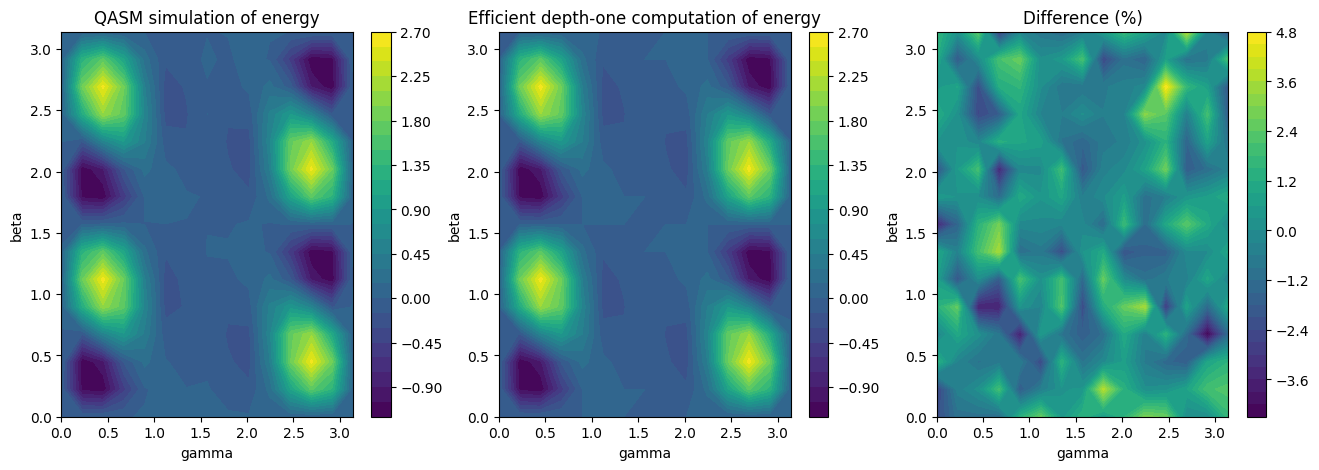

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ggs, bbs = np.meshgrid(gammas, betas)
cset1 = axs[0].contourf(ggs, bbs, energies1, levels=30)
cset2 = axs[1].contourf(ggs, bbs, energies2, levels=30)
cset3 = axs[2].contourf(ggs, bbs, (energies1 - energies2)*100, levels=30)
for ax in axs:
    ax.set_xlabel("gamma")
    ax.set_ylabel("beta")
fig.colorbar(cset1, ax=axs[0])
fig.colorbar(cset2, ax=axs[1])
fig.colorbar(cset3, ax=axs[2])
axs[0].set_title("QASM simulation of energy")
axs[1].set_title("Efficient depth-one computation of energy")
axs[2].set_title("Difference (%)")

Note that the deviation we observe is expected. Indeed, the simulator is a sampling based simulator and we can expect fluctuations of the order of
\begin{align}
\frac{|A|}{\sqrt{N_\text{shots}}}
\end{align}
where $N_\text{shots}$ is the number of shots and $|A|$ is the norm of the energy landscape. This evaluates to

In [34]:
max_range = np.max(energies1) - np.min(energies1)
max_diff = np.max(np.abs(energies1 - energies2))

In [35]:
max_diff

0.04712990904820963

In [36]:
2 * max_range / np.sqrt(2**14)

0.05924415588378906